In [2]:
%pylab qt
%load_ext autoreload
%autoreload 2

[2024-01-24 14:30:47,721] {pyplot.py:414} DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2024-01-24 14:30:47,754] {pyplot.py:414} DEBUG - Loaded backend QtAgg version 5.15.7.
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Load the ggems files

In [1]:
# Loop through the ggems mhd files and save them to an array
import glob
import fastcat as fc
import numpy as np
import matplotlib.pyplot as plt
import mpl_interactions as pli
from mpl_interactions import ipyplot as iplt
# Zoom the ggems projections
from scipy.ndimage import zoom

ggems_scatter_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_fastmc/fastmc_*scatter.mhd'
)
ggems_primary_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_fastmc/fastmc_*[!scatter].mhd'
)

ggems_scatter_files.sort()
ggems_primary_files.sort()

ggems_primary_projections = []
ggems_scatter_projections = []

for ggems_scatter_file, ggems_primary_file in zip(ggems_scatter_files, ggems_primary_files):
    ggems_prmiary, b, c = fc.utils.read_mhd(ggems_primary_file)
    ggems_scatter, b, c = fc.utils.read_mhd(ggems_scatter_file)

    ggems_primary_projections.append(ggems_prmiary.squeeze())
    ggems_scatter_projections.append(ggems_scatter.squeeze())

# Load the flood file
flood_file = '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_fastmc/flood_fastmc.mhd'
ggems_flood, b, c = fc.utils.read_mhd(flood_file)
ggems_flood = ggems_flood.squeeze()

# Load the pickled phantom
pkl_file = '/home/jericho/1-Workspace/1-jupyter_notebooks/2-fastcat_ggems/test/ggems_1e09_121kVp.pkl'
phantom = np.load(pkl_file, allow_pickle=True)

# I flip the phantom because fastmc has a bit of a different coordinate system
phantom.phantom = np.flipud(phantom.phantom)

phantom.simulation_parameters['angles'] = phantom.angles

# Convert the phantom angles to degrees
phantom_angles = phantom.angles * 180 / np.pi

# Define the denoising functions
def downsize_block(image, block_size):
    image_size = image.shape[0]
    block_size = int(block_size)
    downsize = image_size//block_size
    image = image[:downsize*block_size, :downsize*block_size]
    image = image.reshape(downsize, block_size, downsize,
                          block_size).mean(axis=(1, 3))
    return image

def denoise_projections(projections):
    projections_zoomed = []

    projections = np.array(projections)
    # Check if the array is 3D
    if projections.ndim == 2:
        projections = projections[np.newaxis, :, :]
    for projection in projections:
        projection_zoomed_downsized = downsize_block(projection, 64)
        projection_zoomed = zoom(
            projection_zoomed_downsized, 64, order=4, mode='nearest')
        # Adjust the mean of the zoomed image to match the original
        projection_zoomed = projection_zoomed * \
            np.mean(projection) / np.mean(projection_zoomed)
        projections_zoomed.append(projection_zoomed)
    
    return projections_zoomed

# zoom the scatter projections using the zoom from function
ggems_scatter_denoised = denoise_projections(np.array(ggems_scatter_projections).sum(axis=0))

Fastcat simulation

In [3]:
# Get the simulation parameters
simulation_parameters = phantom.simulation_parameters
detector_material = simulation_parameters['detector_material']
spectrum_file = '/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/data/spectrum_120kVp_2mmAl.dat'

# Load the spectrum as a fastcat spectrum object
s = fc.Spectrum()
s.load(spectrum_file=spectrum_file)

det = fc.Detector(s,'CsI-784-micrometer')
# angles = np.deg2rad([0,144,216,288,72])
angles = np.linspace(0, np.pi *2, 180, endpoint=False)

phantom.bowtie_file = '/home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat'
phantom.bowtie_interp = 'cubic'
# return the projections
# phantom.phantom = np.flipud(phantom.phantom)
phantom.return_projs(det,s,angles,mgy=0,
                    ASG=False, scat_on=False,
                    det_on=False,
                    bowtie=True,
                    return_intensity=True)# Get primary fastcat projections

[2024-01-24 14:30:51,633] {ggems_simulate.py:227} INFO - Initializing filter /home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat


[2024-01-24 14:30:52,532] {ggems_simulate.py:618} INFO - Running Simulations
[2024-01-24 14:30:52,532] {ggems_simulate.py:646} INFO -     Simulating 10 keV
[2024-01-24 14:30:58,570] {ggems_simulate.py:646} INFO -     Simulating 20 keV
[2024-01-24 14:31:06,005] {ggems_simulate.py:646} INFO -     Simulating 30 keV
[2024-01-24 14:31:13,424] {ggems_simulate.py:646} INFO -     Simulating 40 keV
[2024-01-24 14:31:20,747] {ggems_simulate.py:646} INFO -     Simulating 50 keV
[2024-01-24 14:31:28,103] {ggems_simulate.py:646} INFO -     Simulating 60 keV
[2024-01-24 14:31:35,339] {ggems_simulate.py:646} INFO -     Simulating 70 keV
[2024-01-24 14:31:41,260] {ggems_simulate.py:646} INFO -     Simulating 80 keV
[2024-01-24 14:31:48,507] {ggems_simulate.py:646} INFO -     Simulating 90 keV
[2024-01-24 14:31:54,179] {ggems_simulate.py:646} INFO -     Simulating 100 keV
[2024-01-24 14:31:59,835] {ggems_simulate.py:876} INFO - Weighting simulations
[2024-01-24 14:31:59,836] {ggems_simulate.py:965} INF

In [4]:
phantom.load_ggems_files(ggems_scatter_files, ggems_primary_files, flood_file,
                         average_scatter=True)

In [5]:
phantom.correct_intensity(ml=False)

In [6]:
phantom.ggems_scatter_denoised.shape

(5, 512, 512)

In [7]:
phantom.interpolate_ggems_scatter()

ValueError: fp and xp are not of the same length.

In [8]:
plt.figure()
cont = pli.hyperslicer(phantom.intensity)

[2024-01-24 14:33:01,091] {font_manager.py:1411} DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2024-01-24 14:33:01,092] {font_manager.py:1423} DEBUG - findfont: score(FontEntry(fname='/home/jericho/anaconda3/envs/tigre_fastcat/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-01-24 14:33:01,092] {font_manager.py:1423} DEBUG - findfont: score(FontEntry(fname='/home/jericho/anaconda3/envs/tigre_fastcat/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-01-24 14:33:01,092] {font_manager.py:1423} DEBUG - findfont: score(FontEntry(fname='/home/jericho/anaconda3/envs/tigre_fastcat/lib/python3.11/site-packages/matplotlib/mpl-data/fonts

libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [ ]:
phantom.calc_ggems_projections(scat_on=False)

In [ ]:
plt.figure()
# plt.subplot(121)
controls = pli.hyperslicer(phantom.ggems_projections, autoscale_cmap=False,cmap='jet')
# plt.subplot(122)
# controls = pli.hyperslicer(phantom.ggems_primary_projections, controls=controls, autoscale_cmap=False,cmap='jet')

In [28]:
plt.figure()
plt.imshow(phantom.flood_field)

In [35]:
phantom.reconstruct_ggems(algo='FDK')

In [16]:
# low_res_bowtie = phantom.img

In [44]:
fig = plt.figure(figsize=(10,5))
# Hyperslicer with vmin and vmax set to one standard deviation from the mean
plt.subplot(121)
# Change the images into Houndsfield units using the center of the phantom
low_res_bowtie_HU = low_res_bowtie/np.mean(low_res_bowtie[20:-20,200:-200, 200:-200])
low_res_bowtie_HU = (low_res_bowtie_HU-1)*1000
cc = pli.hyperslicer(low_res_bowtie_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400)
plt.colorbar()
plt.title('Low res bowtie [HU]')
plt.axis('off')
plt.subplot(122)
hi_res_bowtie_HU = phantom.img/np.mean(phantom.img[20:-20,200:-200, 200:-200])
hi_res_bowtie_HU = (hi_res_bowtie_HU-1)*1000
pli.hyperslicer(hi_res_bowtie_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400,controls=cc)
plt.colorbar()
plt.title('High res bowtie [HU]')
plt.axis('off')

[2024-01-19 10:28:02,897] {colorbar.py:859} DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f873abfc650>
[2024-01-19 10:28:03,126] {colorbar.py:859} DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f873ac447d0>


(-0.5, 525.5, 525.5, -0.5)

In [46]:
cc.save_animation('bowtie_comparison.gif',fig, 'axis0', interval=20)

[2024-01-19 10:29:25,591] {animation.py:1060} INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2024-01-19 10:29:25,592] {animation.py:322} DEBUG - frame size in pixels is 1302 x 500
[2024-01-19 10:29:25,593] {animation.py:338} INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1302x500 -pix_fmt rgba -framerate 50.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y bowtie_comparison.gif
[2024-01-19 10:29:25,597] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2024-01-19 10:29:25,641] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2024-01-19 10:29:25,686] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2024-01-19 10:29:25,727] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2024-01-19 10:29:25,773] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2024-01-19 10:29:25,817] {animation.py:366} DEBUG - MovieWrit

In [54]:
from pylinac.core.image import XIM


my_xim_files = glob.glob("/home/jericho/Software/kv_catphan_600/*.xim")

ximages = []
for my_xim_file in my_xim_files:
    xim_img = XIM(my_xim_file)
    xim_img.save_as(my_xim_file.replace('.xim','.png'))


In [ ]:

from PIL import Image

images = []
for my_xim_file in my_xim_files:
    images.append(Image.open(my_xim_file.replace('.xim','.png')))

plt.figure()
pli.hyperslicer(np.array(images),autoscale_cmap=False,cmap='jet')

In [ ]:

# plot the image
xim_img.plot()

# see the XIM properties
print(xim_img.properties)

Compare the two

In [16]:
# Define a standard scaler function
def standard_scaler(image):
    image = image - np.mean(image)
    image = image / np.std(image)
    return image

gg_primary = ggems_primary_projections[0] - ggems_scatter_denoised[0]
# Scale the first
plt.figure()
plt.subplot(1,2,1)
plt.imshow(standard_scaler(np.rot90(phantom.intensity[0],3)),
           vmin=np.percentile(standard_scaler(np.rot90(phantom.intensity[0],3)),1),
           vmax=np.percentile(standard_scaler(np.rot90(phantom.intensity[0],3)),99))
plt.title('Primary')
plt.subplot(1,2,2)
# Plot the ggems primary
plt.imshow(standard_scaler(gg_primary),
           vmin=np.percentile(standard_scaler(gg_primary),1),
           vmax=np.percentile(standard_scaler(gg_primary),99))

plt.figure()
pli.heatmap_slicer(np.arange(gg_primary.shape[0]), np.arange(gg_primary.shape[1]),
                   [standard_scaler(gg_primary), 
                    standard_scaler(np.rot90(phantom.intensity[0],3))],slices='both')


(<Figure size 1800x900 with 4 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'heatmap_1'}, xlabel='X'>,
        <Axes: title={'center': 'Horizontal'}>,
        <Axes: title={'center': 'Vertical'}>], dtype=object))

In [29]:
ggems_primary_only = np.array(ggems_primary_projections) - np.array(ggems_scatter_projections)

# phantom.intensity[0] = np.rot90(phantom.intensity[0],3)
# Set the mean and standard deviation of the ggems primary only projections to match the fastcat projections
def normalize_mean_and_std(array1,array2):
    array1 = array1 - np.mean(array1)
    array1 = array1 * np.std(array2) / np.std(array1)
    array1 = array1 + np.mean(array2)
    return array1

phantom_projections = normalize_mean_and_std(phantom.intensity, ggems_primary_only)

In [30]:
plt.figure()
pli.heatmap_slicer(np.arange(gg_primary.shape[0]), np.arange(gg_primary.shape[1]),
                   [ggems_primary_only[0], 
                    np.rot90(phantom_projections[0],3)],slices='both')

(<Figure size 1800x900 with 4 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'heatmap_1'}, xlabel='X'>,
        <Axes: title={'center': 'Horizontal'}>,
        <Axes: title={'center': 'Vertical'}>], dtype=object))

In [42]:

# Set up a shallow neural network to map the fastcat projections to the ggems_primary_only projections using sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

crop = 10 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.rot90(phantom_projections[0,crop:-crop,crop:-crop],3).flatten()[::4], ggems_primary_only[0,crop:-crop,crop:-crop].flatten()[::4], test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, 1))
X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1))

# # Define the neural network
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10),
                   activation='relu',
                   solver='adam',
                   max_iter=100,
                   verbose=True,
                   random_state=42)

# Use an svm instead of a neural network
# from sklearn.svm import SVR
# mlp = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

# Train the neural network
mlp.fit(X_train_scaled, y_train)

# Predict the test data
predictions = mlp.predict(X_test_scaled)

# Plot the predictions vs the actual data
plt.figure()
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plot the residuals
plt.figure()
plt.scatter(y_test, y_test - predictions)
plt.xlabel('True Values')
plt.ylabel('Residuals')

# Calculate the mean squared error
print('Mean squared error: ', mean_squared_error(y_test, predictions))

Iteration 1, loss = 43197800.52378173
Iteration 2, loss = 42455027.70495602
Iteration 3, loss = 38318244.85262971
Iteration 4, loss = 27277489.88555097
Iteration 5, loss = 12240312.22074666
Iteration 6, loss = 2906743.34269806
Iteration 7, loss = 690142.32278253
Iteration 8, loss = 353339.28815219
Iteration 9, loss = 268411.45323221
Iteration 10, loss = 246582.02050004
Iteration 11, loss = 242416.05019510
Iteration 12, loss = 241749.93267820
Iteration 13, loss = 241600.59008099
Iteration 14, loss = 241536.81635817
Iteration 15, loss = 241592.45608466
Iteration 16, loss = 241529.16934508
Iteration 17, loss = 241462.33793598
Iteration 18, loss = 241519.81200143
Iteration 19, loss = 241546.90510255
Iteration 20, loss = 241557.04800578
Iteration 21, loss = 241576.06545130
Iteration 22, loss = 241549.02893141
Iteration 23, loss = 241496.43016831
Iteration 24, loss = 241525.48577915
Iteration 25, loss = 241599.10735076
Iteration 26, loss = 241525.93327584
Iteration 27, loss = 241565.83485428

In [43]:
# Use the neural network to predict the ggems primary only projections from the fastcat projections
ggems_primary_only_nn = []
for projection in phantom_projections:
    projection_scaled = scaler.transform(projection.flatten().reshape(-1, 1))
    projection_nn = mlp.predict(projection_scaled)
    projection_nn = projection_nn.reshape(projection.shape)
    ggems_primary_only_nn.append(np.rot90(projection_nn,3))

# scale the ggems neural network projections to match the fastcat projections
ggems_fastcat_nn = normalize_mean_and_std(np.array(ggems_primary_only_nn), np.array(ggems_primary_only))

In [44]:
perc_diff_primary = (np.array(ggems_primary_only)-np.array(ggems_fastcat_nn[-1::-1]))/np.max(ggems_primary_only)*100

plt.figure()
ctrl = pli.hyperslicer(np.array(perc_diff_primary), cmap='bwr',
                        vmax=5,vmin=-5)

In [23]:
phantom_projections = ggems_fastcat_nn

# Downsize the perc_diff using the downsize_block function
perc_diff = (np.array(ggems_scatter_denoised)-np.array(ggems_scatter_projections))/np.max(ggems_scatter_projections)*100
perc_diff_small = []
for i in range(len(perc_diff)):
    perc_diff_small.append(downsize_block(perc_diff[i], 16))

# Plot the ggems projections
fig, (axes) = plt.subplots(ncols=2, nrows=3, figsize=(5.8,10))

# Plot the denoised ggems projections
controls = pli.hyperslicer(np.array(ggems_scatter_denoised),
                           ax=axes[1][0], cmap='jet',vmax=np.percentile(np.array(ggems_scatter_denoised),99),
                           vmin=np.percentile(np.array(ggems_scatter_denoised),1),play_buttons=True)
axes[1][0].set_title('Denoised GGEMS scatter')

ggems_primary_only = np.array(ggems_primary_projections) - np.array(ggems_scatter_projections)

# Plot the ggems projections
c2 = pli.hyperslicer(np.array(ggems_primary_only), ax=axes[0][1], cmap='gray',controls=controls,
                     vmax=np.percentile(np.array(ggems_primary_only),99),
                     vmin=np.percentile(np.array(ggems_primary_only),1))
axes[0][1].set_title('GGEMS Primary')

# Plot the phantom phantom_projections
c1 = pli.hyperslicer(np.array(phantom_projections)[-1::-1], ax=axes[1][1], cmap='gray',controls=controls,
                     vmax=np.percentile(np.array(phantom_projections),99),
                     vmin=np.percentile(np.array(phantom_projections),1))
axes[1][1].set_title('Analytical Primary')

# Plot the difference between the ggems and phantom projections
perc_diff_primary = (np.array(ggems_primary_only)-np.array(phantom_projections[-1::-1]))/np.max(phantom_projections)*100

c4 = pli.hyperslicer(np.array(perc_diff_primary), ax=axes[2][1], cmap='bwr',controls=controls,
                        vmax=5,vmin=-5)
axes[2][1].set_title('Perc. Diff. [%]')

# Add a colorbar
plt.colorbar(ax=axes[2][1])

# Plot the ggems projections
c2 = pli.hyperslicer(np.array(ggems_scatter_projections), ax=axes[0][0], cmap='jet',controls=controls,
                     vmax=np.percentile(np.array(ggems_scatter_projections),99),
                     vmin=np.percentile(np.array(ggems_scatter_projections),1))

axes[0][0].set_title('GGEMS Scatter')

# Plot the ggems primary projections
c3 = pli.hyperslicer(np.array(perc_diff_small),ax=axes[2][0], cmap='bwr',vmax=5,vmin=-5,controls=controls)
plt.colorbar(ax=axes[2][0])
axes[2][0].set_title('Perc. Diff. [%]')
plt.tight_layout()

# Turn off the axes
for ax in axes.flatten():
    ax.axis('off')
# Define a function that given an angle and radius returns x and y coordinates
# def f(axis0,radius=220,offset=0,x0=256,y0=256,na=90):
#     angle = np.deg2rad(axis0*360/na)
#     x = radius * np.cos(angle+offset) + x0
#     y = radius * np.sin(angle+offset) + y0
#     return np.array([[x,y],[x,y],[x,y]])

# iplt.plot(f, ax=axes[4], a=(0.1,10), b=(0.1,10), parametric=True,ylim=[0,1],xlim=[1,na],play_buttons=True)
# plt.imshow(phantom.phantom[50, :, :], cmap='gray')
# iplt.scatter(f, ax=axes[3][0], controls=controls,play_buttons=True,c='r',marker='>',parametric=True,)

# Add a label in the image saying source position
# axes[3].text(50, 50, 'Source Position', color='r', fontsize=12)


[2023-12-11 13:14:51,452] {colorbar.py:859} DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f78a62b7ed0>
[2023-12-11 13:14:51,880] {colorbar.py:859} DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f78a6360750>


In [48]:
# Save the figure as a gif using mpl_interactions
# save as a gif
anim = controls.save_animation("phantoms_ggems_analytical+denoised.gif", fig, "axis0", interval=120)

[2023-12-07 16:51:50,649] {animation.py:1060} INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2023-12-07 16:51:50,649] {animation.py:322} DEBUG - frame size in pixels is 580 x 964
[2023-12-07 16:51:50,650] {animation.py:338} INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 580x964 -pix_fmt rgba -framerate 8.333333333333334 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y phantoms_ggems_analytical+denoised.gif
[2023-12-07 16:51:50,655] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2023-12-07 16:51:50,748] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2023-12-07 16:51:50,836] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2023-12-07 16:51:50,927] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2023-12-07 16:51:51,015] {animation.py:366} DEBUG - MovieWriter.grab_frame: Grabbing frame.
[2023-12-07 16:51:51,105] {animati

In [24]:
# Plot the error between the ggems and phantom projections as a function of angle in terms of rmse 
rmse = []
rmse_scatter = []
for i in range(len(phantom_projections)):
    rmse_scatter.append(np.sqrt(np.mean(np.array(perc_diff_small[i])**2)))
    rmse.append(np.sqrt(np.mean(np.array(perc_diff_primary[i])**2)))

plt.figure()
plt.plot(angles,rmse_scatter,label='Scatter')
plt.plot(angles,rmse,label='Primary')
plt.xlabel('Angle [degrees]')
plt.ylabel('RMSE [%]')
plt.legend()
plt.title('RMSE vs Angle')


Text(0.5, 1.0, 'RMSE vs Angle')

In [59]:
# Read and plot the spectrum_file
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mpl_interactions as pli

# Read the spectrum file
spectrum_file = '/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/data/spectrum_120kVp_2mmAl.dat'
spectrum = np.loadtxt(spectrum_file, skiprows=0)
plt.figure()
plt.plot(spectrum[:,0],spectrum[:,1])
plt.xlabel('Energy [keV]')
plt.ylabel('Intensity [photons/s/0.1%bw]')
plt.title('Spectrum')

np.sum(spectrum[:,1])

[2024-01-19 15:08:25,535] {pyplot.py:414} DEBUG - Loaded backend QtAgg version 5.15.7.


0.9999999997000002

In [17]:
import spekpy as sp

s = sp.Spek(120,14)

In [18]:
# Filter the spectrum with 0.89 mm of Ti
# Filter the spectrum with 2.75 mm of Al

s.filter('Al', 2.75)
s.filter('Ti', 0.89)

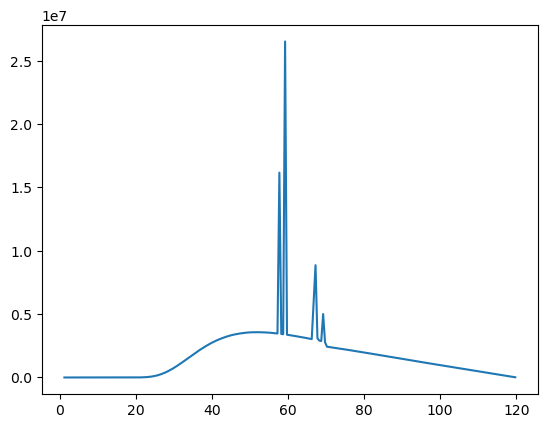

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(s.get_spectrum()[0],s.get_spectrum()[1])

In [13]:
# Write the spectrum to a text file with the first column being the energy and the second column being the intensity seperated by a space
xx, yy = s.get_spectrum()

yy /= np.sum(yy)
xx /= 1000

xx = np.round(xx,6)
yy = np.round(yy,6)

yy /= np.sum(yy)

np.savetxt('spectrum_120kVp_2.75mmAl_0.89mmTi.dat',np.transpose([xx,yy]),delimiter=' ',fmt='%1.10f')

In [16]:
sum(np.round(yy,10))

0.9999999999999997

In [67]:
# Load the file back and plot it
spectrum_file = 'spectrum_120kVp_2mmAl_0.89mmTi.dat'
spectrum = np.loadtxt(spectrum_file, skiprows=0)
plt.figure()
plt.plot(spectrum[:,0],spectrum[:,1])
plt.xlabel('Energy [keV]')
plt.ylabel('Intensity [photons/s/0.1%bw]')
plt.title('Spectrum')

Text(0.5, 1.0, 'Spectrum')

In [102]:
mean_projection = np.mean(np.array(ggems_projections), axis=0)
mean_projection_zoom = zoom(downsize_block(
    mean_projection, 64), 64, order=5, mode='nearest')

pli.heatmap_slicer(np.arange(0, mean_projection.shape[0]),
                   np.arange(0, mean_projection.shape[1]),
                   (mean_projection, mean_projection_zoom),
                   cmap='jet',
                   slices='both')

(<Figure size 1800x900 with 4 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'heatmap_1'}, xlabel='X'>,
        <Axes: title={'center': 'Horizontal'}>,
        <Axes: title={'center': 'Vertical'}>], dtype=object))

In [101]:
# Do the same thing but for RectBivariateSpline
from scipy.interpolate import RectBivariateSpline
import numpy as np

ggems_projections_downsized_spline = []
for ggems_projection in ggems_projections_downsized:
    # Initialize the spline
    spline = RectBivariateSpline(np.arange(ggems_projection.shape[0]), np.arange(
        ggems_projection.shape[1]), ggems_projection, kx=4, ky=4, s=2)
    # Evaluate the spline on a finer grid
    x_fine, y_fine = np.meshgrid(np.linspace(0, ggems_projection.shape[0], ggems_projection.shape[0]*4), np.linspace(
        0, ggems_projection.shape[1], ggems_projection.shape[1]*4))
    z_fine = spline.ev(x_fine, y_fine)

    ggems_projections_downsized_spline.append(z_fine)

# Plot the ggems projections
plt.figure()
controls = pli.hyperslicer(
    np.array(ggems_projections_downsized_spline), cmap='jet')

Init signature:
RectBivariateSpline(
    x,
    y,
    z,
    bbox=[None, None, None, None],
    kx=3,
    ky=3,
    s=0,
)
Docstring:     
Bivariate spline approximation over a rectangular mesh.

Can be used for both smoothing and interpolating data.

Parameters
----------
x,y : array_like
    1-D arrays of coordinates in strictly ascending order.
    Evaluated points outside the data range will be extrapolated.
z : array_like
    2-D array of data with shape (x.size,y.size).
bbox : array_like, optional
    Sequence of length 4 specifying the boundary of the rectangular
    approximation domain, which means the start and end spline knots of
    each dimension are set by these values. By default,
    ``bbox=[min(x), max(x), min(y), max(y)]``.
kx, ky : ints, optional
    Degrees of the bivariate spline. Default is 3.
s : float, optional
    Positive smoothing factor defined for estimation condition:
    ``sum((z[i]-f(x[i], y[i]))**2, axis=0) <= s`` where f is a spline
    function. Defa

In [81]:
phantom = np.load(
    '/home/jericho/Software/fastcat/fastcat/data/phantoms/ct_scan_head_mandible_large.npy')

In [84]:
plt.figure()
contr = pli.hyperslicer(phantom)

In [85]:
# load a binary file to an array
import numpy as np

phantom = np.load()

In [86]:
plt.figure()
pli.hyperslicer(phantom.phantom)

AttributeError: 'Controls' object has no attribute 'vbox'